In [1]:
from streaming.base.format.mds.encodings import Encoding, _encodings
from streaming import MDSWriter, LocalDataset
from tqdm import tqdm
from typing import List
import torch
import json

class ListOfDict(Encoding):
    def encode(self, obj: List[dict]) -> bytes:
        # Convert the list of dictionaries to a JSON-encoded string
        json_str = json.dumps(obj)
        return json_str.encode('utf-8')

    def decode(self, data: bytes) -> List[dict]:

        # Decode the JSON-encoded string back to a list of dictionaries
        json_str = data.decode('utf-8')
        return json.loads(json_str)

# Register the custom encoding for 'list_of_dict'
_encodings['list_of_dict'] = ListOfDict

In [2]:
from glob import glob

files = glob('prepared-llava*.jsonl')
files.extend(glob('prepared-combine*.jsonl'))
files.extend(glob('prepared-relationship*.jsonl'))
files.extend(glob('prepared-malay*'))

files

['prepared-llava-en.jsonl',
 'prepared-llava-ms.jsonl',
 'prepared-combine-ms.jsonl',
 'prepared-combine-en.jsonl',
 'prepared-relationship-en.jsonl',
 'prepared-relationship-ms.jsonl',
 'prepared-malay.jsonl']

In [3]:
columns = {
    'conversations': 'list_of_dict',
    'filename': 'list_of_dict'
}

hashes = 'sha1', 'xxh64'

In [4]:
!rm -rf mosaic-multimodal-vision

In [5]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('mesolitica/malaysian-tinyllama-1.1b-16k-instructions-v3')
tokenizer.add_tokens(["<image>", "</image>", "<audio>", "</audio>"])

4

In [6]:
with MDSWriter(out='mosaic-multimodal-vision', columns=columns, compression=None, hashes=hashes) as out:
    for f in files:
        with open(f) as fopen:
            for l in tqdm(fopen):
                try:
                    l = json.loads(l)
                    rejected = False
                    for i in range(len(l['filename'])):
                        l['filename'][i] = l['filename'][i].replace('/output-audio', '/filter-audio')
                    for i in range(len(l['conversations'])):
                        l['conversations'][i]['content'] = l['conversations'][i]['content'].replace('\n<image>', ' <image>').replace('<image>\n', '<image> ').replace('\n<audio>', ' <audio>').replace('<audio>\n', '<audio> ').strip()
                        l['conversations'][i]['content'] = l['conversations'][i]['content'].replace('<image>', '<image> </image>').replace('<audio>', '<audio> </audio>')
                        if i == 0 and l['conversations'][i]['role'] == 'user' and '<image> </image>' not in l['conversations'][i]['content']:
                            print(l)
                            rejected = True
                            break
                    if rejected:
                        continue
                    a = tokenizer.apply_chat_template(l['conversations'], tokenize = False)
                    a = tokenizer(a, return_tensors = 'np')['input_ids'][0]
                    if len(a[a == 32000]) != len(l['filename']):
                        print(l)
                        continue
                    if len(a[a == 32001]) != len(l['filename']):
                        print(l)
                        continue
                    out.write(l)
                except Exception as e:
                    print(l, e)

148657it [01:51, 1334.46it/s]
148657it [02:03, 1203.51it/s]
20000it [00:36, 543.65it/s]
20000it [00:32, 613.64it/s]
100000it [00:36, 2708.26it/s]
100000it [00:38, 2577.49it/s]
3238it [00:01, 2641.54it/s]


In [7]:
dataset = LocalDataset('mosaic-multimodal-vision')
len(dataset)

540552

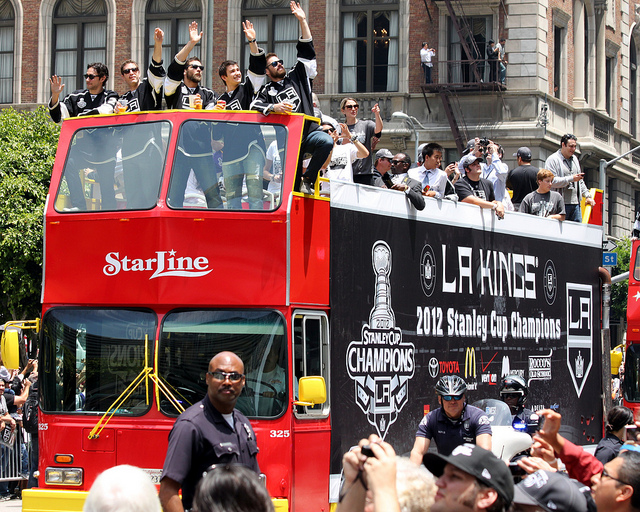

In [8]:
from PIL import Image

Image.open(dataset[10000]['filename'][0])

In [9]:
dataset[10000]

{'conversations': [{'role': 'user',
   'content': '<image> </image> What are the key elements in this picture?'},
  {'role': 'assistant',
   'content': "The image features a double-decker bus with an open top, driving through a busy city filled with people, including a number of individuals wearing hockey jerseys. These people are part of the LA Kings hockey team, waving to bystanders from the open top of their 2012 tour bus. \n\nThere are multiple passengers on both levels of the bus. On the lower level, several people wearing LA Kings jerseys are visible through the windows, while more people can also be seen on the upper, open level of the bus. Surrounding the bus, there's a motorcycle on the road and a few people holding cell phones, possibly taking pictures or capturing the moment. Overall, the atmosphere seems lively and exciting, with many people participating in and witnessing the event."}],
 'filename': ['/home/ubuntu/translated-LLaVA-Instruct-150K/filtered-llava-images/000000